In [90]:
MODEL_TYPES = ["Full", "New Features"]

MODEL_TYPE = MODEL_TYPES[1]

In [91]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly.express as px
%matplotlib inline

#### Load the CSV Data

In [92]:
df = pd.read_csv('../../../../data/cardio_train.csv', delimiter=';')


# Data Meaning Type


The cardiovascular dataset consists of 11 features and 1 target variable. Attribute descriptions can be found on [Kaggle](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset). They are provided below.

There are 3 types of input features in the data set.
- **Objective**: factual information
- **Examination**:  results from a medical examination
- **Subjective**:  response provided by patient



**Table 1: Cardiovascular Dataset - Attribute Descriptions**

| Column Description | Feature Type | Column Name | Data Type |
|:---|:---|:---|:---|
| **Age**                        | Objective | age | int (days) |
| **Height**                     | Objective | height | int (cm) |
| **Weight**                     | Objective | weight | float (kg) |
| **Gender**                     | Objective | gender | 1: female, 2: male |
| **Systolic blood pressure**    | Examination | ap_hi | int |
| **Diastolic blood pressure**   | Examination | ap_lo | int |
| **Cholesterol**                | Examination | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| **Glucose**                    | Examination | gluc | 1: normal, 2: above normal, 3: well above normal |
| **Smoking**                    | Subjective | smoke | binary |
| **Alcohol intake**             | Subjective | alco | binary |
| **Physical activity**          | Subjective | active | binary |
| **Has CVD?**                   | Target | cardio | binary |

We decided to use the `id` column as the index as it appears to be a unique identifier for the subject.

In [93]:
df.set_index("id", inplace=True)

In [94]:
df.index.is_unique

True

# Data Quality


In [95]:
df_clean = df.copy(deep=True)

In [96]:
df_clean.drop_duplicates(inplace=True)

We'll remove the duplicates entirely, as this should not affect the ability of our models to make predictions with the amount of observations at our disposal. 

## Transformations

In [97]:
# %%time
# df_clean['age'] = df_clean['age'].apply(lambda x: round(x / 365))
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

`Age` was provided in `days`, and for the sake of interpretability we'll be converting this to years for all observations.

In [98]:

df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

In [99]:
df_clean.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,1,168,62.0,110,80,1,1,0,0,1,0
1,55,0,156,85.0,140,90,3,1,0,0,1,1
2,52,0,165,64.0,130,70,3,1,0,0,0,1
3,48,1,169,82.0,150,100,1,1,0,0,1,1
4,48,0,156,56.0,100,60,1,1,0,0,0,0


## Outliers

In [100]:
plt.style.use('ggplot')

In [101]:
df_clean.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.338945,0.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,6.765633,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,30.000000,0.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,65.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


## Imputation

#### Age

In [102]:
median_age = df_clean['age'].median()

In [103]:
age_outlier_ids = df_clean.index[(np.abs(df_clean['age'] - df_clean['age'].mean()) > (3 * df_clean['age'].std()))]

In [104]:
df_clean.loc[df_clean.index.isin(age_outlier_ids), "age"] = np.nan

In [105]:
df_clean.loc[df_clean.index.isin(age_outlier_ids)].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
8850,NaN,0,175,59.0,120,80,1,1,0,0,1,0
31922,NaN,1,175,92.0,100,60,1,1,0,0,1,0
43842,NaN,0,159,59.0,120,80,1,1,0,0,1,0
79749,NaN,0,160,59.0,110,70,1,1,0,0,1,0


We've imputed observations with an `age` of more than `three standard deviations` from the mean with the median value. (~4 observations in total)  These may well have been valid observations but we wanted our model to extend well to other new and unseen data sets.

#### Height

In [106]:
median_height = df_clean['height'].median()

In [107]:
height_outlier_ids = df_clean.index[(np.abs(df_clean['height'] - df_clean['height'].mean()) > (3 * df_clean['height'].std()))]


In [108]:
df_clean.loc[df_clean.index.isin(height_outlier_ids), "height"] = np.nan

In [109]:
df_clean.loc[df_clean.index.isin(height_outlier_ids)].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
309,60.0,1,NaN,55.0,120,80,1,1,0,0,1,0
1432,42.0,1,NaN,111.0,148,86,1,1,0,0,1,1
1554,61.0,1,NaN,68.0,120,80,1,1,0,0,1,1
3049,44.0,1,NaN,74.0,140,90,1,1,1,1,1,1
3399,62.0,1,NaN,52.0,140,100,1,1,0,0,1,1


We've imputed observations with a `height` more than three standard deviations from the mean with the median value. (~287 observations in total)

#### Weight

In [110]:
median_weight = df_clean['weight'].median()

In [111]:
weight_outlier_ids = df_clean.index[(np.abs(df_clean['weight'] - df_clean['weight'].mean()) > (3 * df_clean['weight'].std()))]


In [112]:
df_clean.loc[df_clean.index.isin(weight_outlier_ids), "weight"] = np.nan


In [113]:
df_clean.loc[df_clean.index.isin(weight_outlier_ids)].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
474,58.0,0,157.0,NaN,120,80,1,1,0,0,1,1
552,46.0,1,165.0,NaN,120,80,1,1,0,0,1,0
618,46.0,0,186.0,NaN,130,70,1,1,0,0,0,0
634,58.0,1,178.0,NaN,160,90,1,3,0,0,1,1
846,40.0,0,164.0,NaN,130,90,1,1,0,0,0,0


The same method was applied to the 702 `weight` outliers.

#### Systolic blood pressure (ap_hi)

In [114]:
median_ap_hi = df_clean['ap_hi'].median()

In [115]:
ap_hi_outlier_ids = df_clean.index[(np.abs(df_clean['ap_hi'] - df_clean['ap_hi'].mean()) > (3 * df_clean['ap_hi'].std()))]


In [116]:
df_clean.loc[df_clean.index.isin(ap_hi_outlier_ids), "ap_hi"] = np.nan

In [117]:
df_clean.loc[df_clean.index.isin(ap_hi_outlier_ids)].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
2654,41.0,0,160.0,60.0,NaN,60,1,1,0,0,1,0
2845,62.0,1,167.0,59.0,NaN,0,1,1,0,0,1,0
6822,40.0,0,168.0,63.0,NaN,60,2,1,0,0,1,0
11089,58.0,0,175.0,80.0,NaN,90,1,1,0,0,1,1
12710,52.0,0,164.0,75.0,NaN,80,2,1,0,0,1,1


In [118]:
ap_hi_outlier_ids2 = df_clean.index[(df_clean['ap_hi'] < 40) | (df_clean['ap_hi'] > 300)]


In [119]:
df_clean.loc[df_clean.index.isin(ap_hi_outlier_ids2), "ap_hi"] = np.nan

Even after handling the `ap_hi` outliers through the standard deviation method, there were still some unusual entries that were manually addressed.  (readings less that 40 or greater than 300)

#### Diastolic blood pressure (ap_lo)

In [120]:
median_ap_lo = df_clean['ap_lo'].median()

In [121]:
ap_lo_outlier_ids = df_clean.index[(np.abs(df_clean['ap_lo'] - df_clean['ap_lo'].mean()) > (3 * df_clean['ap_lo'].std()))]

In [122]:
df_clean.loc[df_clean.index.isin(ap_lo_outlier_ids), "ap_lo"] = np.nan

In [123]:
df_clean.loc[df_clean.index.isin(ap_lo_outlier_ids)].head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
314,48.0,1,183.0,98.0,160.0,NaN,1,2,1,0,1,1
334,60.0,1,157.0,60.0,160.0,NaN,2,1,0,0,0,1
357,50.0,0,150.0,83.0,140.0,NaN,1,1,0,0,1,1
458,64.0,0,176.0,63.0,160.0,NaN,2,2,0,0,0,1
482,51.0,0,154.0,81.0,140.0,NaN,2,1,0,0,1,1


In [124]:
ap_lo_outlier_ids2 = df_clean.index[(df_clean['ap_lo'] < 40) | (df_clean['ap_lo'] > 300)]

In [125]:
df_clean.loc[df_clean.index.isin(ap_lo_outlier_ids2), "ap_lo"] = np.nan

The `ap_lo` feature needed similar processing.

### Transformations

In [126]:
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2

In [127]:
df_clean['bmiGrp'] = np.where((df_clean.bmi < 18.5), 1, 0)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 18.5) & (df_clean.bmi < 25), 2, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 25) & (df_clean.bmi < 30), 3, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 30), 4, df_clean.bmiGrp)

In [128]:
df_clean['bp'] = np.where((df_clean.ap_hi < 120) & (df_clean.ap_lo < 80), 1, 0)
df_clean['bp'] = np.where((df_clean.ap_hi >= 120) & (df_clean.ap_hi < 130) & (df_clean.ap_lo < 80), 2, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 130) & (df_clean.ap_hi < 140) | ((df_clean.ap_lo >= 80) & (df_clean.ap_lo < 90)), 3, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 140) | (df_clean.ap_lo >= 90), 4, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi > 180) | (df_clean.ap_lo > 120), 5, df_clean.bp)

In [129]:
df_clean.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmiGrp,bp
count,69972.000000,69976.000000,69683.000000,69274.000000,69748.000000,68964.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69004.000000,69976.000000,69976.00000
mean,53.340279,0.349648,164.409411,73.660568,127.004373,81.385157,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771,27.295220,2.825526,3.03454
std,6.763525,0.476862,7.724155,13.259621,17.098915,9.693621,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004,4.870912,0.865923,0.98658
min,39.000000,0.000000,140.000000,32.000000,60.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.254473,0.000000,0.00000
25%,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,2.000000,3.00000
50%,54.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.297578,3.000000,3.00000
75%,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.091432,4.000000,4.00000
max,65.000000,1.000000,188.000000,117.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,58.024202,4.000000,5.00000


# Create Models (50 points)

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 



# Model Advantages (10)

Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.


# Interpret Feature Importance (30)

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

# Interpret Support Vectors (10)

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

Store feature matrix 

In [130]:
if MODEL_TYPE == "Full":
    # Full Model
    X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
else:
    # New Feature Model
    X_cols = ['age', 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmiGrp', 'bp']

X = df_clean[X_cols] #.to_numpy()


Store response vector

In [131]:
y = df_clean['cardio'] #.to_numpy()


## Logistic Regression

Full Model consisting of all features with standardized values.


In [132]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

si = SimpleImputer(strategy="median")

X_train_std = si.fit_transform(X_train_std)
X_test_std = si.transform(X_test_std)

logreg = LogisticRegression(n_jobs=-1)
logreg.fit(X_train_std, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [134]:
# sort these attributes and spit them out
zip_vars = zip(logreg.coef_.T, X.columns) # combine attributes
zip_vars = zip_vars # sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

age has weight of 0.3626040076274842
gender has weight of 0.012238421230904583
cholesterol has weight of 0.37130139078093605
gluc has weight of -0.047670870798900866
smoke has weight of -0.029967101824084966
alco has weight of -0.042743903889620766
active has weight of -0.07940342948592896
bmiGrp has weight of 0.14847149949336727
bp has weight of 0.7944330305274281


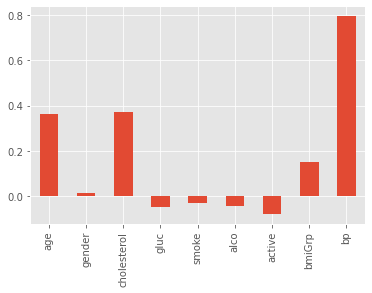

In [135]:
# now let's make a pandas Series with the names and values, and plot them
plt.style.use('ggplot')

weights = pd.Series(logreg.coef_[0],index=X.columns)
weights.plot(kind='bar')
plt.show()

In [136]:
y_pred = logreg.predict(X_test_std)

In [137]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



In [138]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, X_train_std, y_train,
                         scoring="accuracy", cv=3)

def display_scores(scores):
    print("Scores:", scores.round(3))
    print("Mean:", scores.mean().round(3))
    print("Standard deviation:", scores.std().round(3))

display_scores(scores)

Scores: [0.715 0.707 0.714]
Mean: 0.712
Standard deviation: 0.003


In [139]:
if MODEL_TYPE == "Full":
    # Full Model
    num_attribs = ["age", "height", "weight", "ap_hi", "ap_lo"]
    cat_attribs = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
else:
    # With New Features
    num_attribs = ["age", "bmiGrp", "bp"]
    cat_attribs = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]



In [140]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report


num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])


In [141]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(drop="first"), cat_attribs),
    ])

X_prepared = full_pipeline.fit_transform(X)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, stratify=y, test_size=0.2, random_state=1)


In [143]:
logreg = LogisticRegression(n_jobs=-1)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [144]:
y_pred = logreg.predict(X_test)


In [145]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



In [146]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4874 2127]
 [1975 5020]]


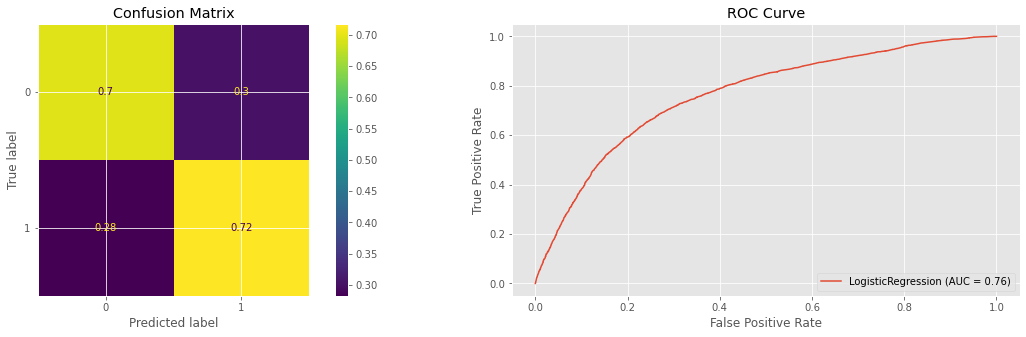

In [147]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

plot_confusion_matrix(logreg, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(logreg, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()

In [148]:

print('Accuracy of the log reg model on the test data: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of the log reg model on the test data: 0.71


In [149]:
from IPython.display import Markdown as md

In [150]:
### Logistic Regression Metrics

md(f"**True Positives:**  {confusion_matrix[1, 1]} \n\n **True Negatives:**  {confusion_matrix[0, 0]} \n\n **False Positives:**  {confusion_matrix[0, 1]} \n\n **False Negatives:**  {confusion_matrix[1, 0]}")


**True Positives:**  5020 

 **True Negatives:**  4874 

 **False Positives:**  2127 

 **False Negatives:**  1975

In [151]:
md(f"**Accuracy:**  { format(( confusion_matrix[1, 1] + confusion_matrix[0, 0] ) / confusion_matrix.sum(), '.3f')}\n\n-how often we were correct overall")

**Accuracy:**  0.707

-how often we were correct overall

In [152]:
md(f"**Error:**  { format(( confusion_matrix[0, 1] + confusion_matrix[1, 0] ) / confusion_matrix.sum(), '.3f')}\n\n-how often we were incorrect overall")

**Error:**  0.293

-how often we were incorrect overall

In [153]:
md(f"**Sensitivity/ Recall:**  { format(( confusion_matrix[1, 1] ) / confusion_matrix[1].sum(axis=0), '.3f')}\n\n-when the patient actually had CVD, how often were we correct")

**Sensitivity/ Recall:**  0.718

-when the patient actually had CVD, how often were we correct

In [154]:
md(f"**Specificity:**  { format(( confusion_matrix[0, 0] ) / confusion_matrix[0].sum(), '.3f')}\n\n-when the patient did not had CVD, how often were we correct")

**Specificity:**  0.696

-when the patient did not had CVD, how often were we correct

In [155]:
md(f"**False Postive Rate:**  { format(( confusion_matrix[0, 1] ) / ( confusion_matrix[0, 0] + confusion_matrix[0, 1] ), '.3f')}\n\n-when the patient did not had CVD, how often were we incorrect")

**False Postive Rate:**  0.304

-when the patient did not had CVD, how often were we incorrect

In [156]:
md(f"**Precision:**  { format(( confusion_matrix[1, 1] ) / ( confusion_matrix[1, 1] + confusion_matrix[0, 1] ), '.3f')}\n\n-how precise were we when classifying the patient as having CVD")

**Precision:**  0.702

-how precise were we when classifying the patient as having CVD

In [157]:
from sklearn.linear_model import SGDClassifier

SGDClassifier(alpha=0.001, class_weight="balanced")
svm_sgd = SGDClassifier() # get object

In [158]:
svm_sgd.fit(X_train, y_train)  # train object

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [159]:
y_pred = svm_sgd.predict(X_test)

In [160]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.69      0.68      0.69      7001
           1       0.69      0.70      0.69      6995

    accuracy                           0.69     13996
   macro avg       0.69      0.69      0.69     13996
weighted avg       0.69      0.69      0.69     13996



In [161]:
from sklearn.svm import LinearSVC

svm_lin = LinearSVC(C=5) # get object
svm_lin.fit(X_train, y_train)  # train object


LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [162]:
y_pred = svm_lin.predict(X_test)

In [163]:
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.71      0.69      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



In [164]:
from sklearn.model_selection import GridSearchCV

# SVC rfb
# paramaters = [{"C": [1, 10, 100, 1000], "kernel": ["rbf"], "gamma": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

# svm_sgd
# paramaters = [{"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1], "class_weight": ["balanced", None]}]

# logistic
# paramaters = [{"C": [1, 10, 100, 1000]}]
# # {'C': 10}

# grid_search = GridSearchCV(estimator = svm_sgd, param_grid=paramaters, scoring="accuracy", cv=10, n_jobs=-1)

# grid_search = grid_search.fit(X_train, y_train)

# accuracy = grid_search.best_score_

# grid_search.best_params_

# svm_best = SVC(kernel='rbf', C=1, gamma=0.1, n_jobs=-1) # get object


In [165]:
# SGDClassifier()
# LogisticRegression
# LinearSVC()

model_params = {
    "sgd": {
        "model": SGDClassifier(n_jobs=-1),
        "params": {
            "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1],
            "class_weight": ["balanced", None]
        }
    },
    "logistic_regression": {
        "model": LogisticRegression(n_jobs=-1),
        "params": {
            "C": [1, 5, 10, 25, 50]
        }
    },
    "linear_svc": {
        "model": LinearSVC(),
        "params": {
            "C": [1, 5, 10, 25, 50]
        }
    }
}

In [166]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=2, scoring="roc_auc")
    clf.fit(X_train, y_train)
    scores.append({"model": model_name,
    "best_score": clf.best_score_, # Mean cross-validated score of the best_estimator
    "best_params": clf.best_params_
    })


In [167]:
import pandas as pd
df = pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
df

,model,best_score,best_params
0,sgd,0.766308,"{'alpha': 0.01, 'class_weight': None}"
1,logistic_regression,0.767676,{'C': 5}
2,linear_svc,0.767229,{'C': 10}


In [168]:
from sklearn.svm import SVC

# svm_best = SVC(kernel='rbf', C=1, gamma=0.1) # get object
# svm_best = SVC() # get object


In [169]:
# svm_best.fit(X_train, y_train)  # train object

In [170]:
# y_pred = svm_best.predict(X_test)

In [171]:
# print(classification_report(y_test, y_pred))

In [172]:
# fig = plt.figure(1, figsize=(20, 5))

# chart_1 = fig.add_subplot(121)
# chart_2 = fig.add_subplot(122)

# plot_confusion_matrix(svm_best, X_test, y_test, normalize='true', ax=chart_1)
# chart_1.set_title('Confusion Matrix')

# plot_roc_curve(svm_best, X_test, y_test, ax=chart_2)
# chart_2.set_title('ROC Curve')

# plt.show()